# Imports

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import json
import random
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats

# Extract cell activity and trial variables form simulation results

In [5]:
# Initialize arrays of interest variables 
# NOTE: each neuron's activity is a row; column index is trial number

N_PFC_NEURONS = 500
N_MD_NEURONS = 2
N_OUTPUT_NEURONS = 2
TRIAL_TIME = 200

s_trial = 0
t_trial = 4800
n_trials = t_trial - s_trial

rPFC_trials = np.zeros((n_trials, TRIAL_TIME, N_PFC_NEURONS))
rMD_trials = np.zeros((n_trials, TRIAL_TIME, N_MD_NEURONS))
task_input = np.zeros((2, n_trials))
v1v2_values = np.zeros((2, n_trials))

# Extract the data

data_dir = "/om2/group/halassa/PFCMD-ali-sabrina/020321_qvals/by_trial"

for i in range(s_trial, t_trial):
    with open(data_dir + "/" + str(i) + ".json") as json_file:
        data = json.load(json_file)
        idx = i - s_trial
                
        rPFC = np.array(data["network_rates"]["r_PFC"])
        rPFC_trials[idx,:,:] = rPFC
        
        rMD = np.array(data["network_rates"]["r_MD"])
        rMD_trials[idx,:,:] = rMD
        
        trial_task_input = np.array(data["trial_data"]["input"])
        task_input[:,idx] = trial_task_input[:2]
        v1v2_values[:,idx] = trial_task_input[2:]


# Compute logistic regression clustering

## Utility functions

In [9]:
def sample_trials_(alevel_idxs, n_samples):
    trial_per_alevel = 400
    trials_offset = 200 # Only consider the second half of the alevel
    
    trials_to_sample = []
    for n_bin in alevel_idxs:
        trial_s = n_bin * trial_per_alevel + trials_offset
        trial_t = (n_bin + 1) * 400
        trials_to_sample = trials_to_sample + list(range(trial_s, trial_t))
    return random.sample(trials_to_sample, n_samples)

def sample_trials():
    alevel_90_idxs = [0, 2, 4, 8, 10]
    alevel_10_idxs = [1, 5, 11]
    alevel_70_idxs = [3, 6]
    alevel_30_idxs = [7]
    alevel_50_idxs = [9]

    alevel_90_trials = sample_trials_(alevel_90_idxs, 100)
    alevel_10_trials = sample_trials_(alevel_10_idxs, 100)
    alevel_70_trials = sample_trials_(alevel_70_idxs, 100)
    alevel_30_trials = sample_trials_(alevel_30_idxs, 100)
    trials = alevel_90_trials + alevel_10_trials + alevel_70_trials + alevel_30_trials #+ alevel_50_trials
    return trials
    
def logistic_regression(X, y):
    try:
        model_fit = sm.Logit(y,X).fit(maxiter=50)
        return model_fit.prsquared
    except np.linalg.LinAlgError:
        return 0
    except sm.tools.sm_exceptions.PerfectSeparationError:
        return 1 # Data is linearly separable

def linear_regression(X, y):    
    model_fit = sm.OLS(y, X).fit()
    
    # Plotting for debugging
#     plt.scatter(X[:,1], y)
#     x_fitline = np.linspace(min(X[:,1]),max(X[:,1]),10)
#     y_fitline = 1.2812 * x_fitline + 0.1760
#     plt.plot(x_fitline, y_fitline, '-r')
#     plt.show()

    return model_fit.rsquared

In [17]:
# N_PFC_NEURONS = 500
CUE_TIME = 100

SAVE_DIR = '/om2/group/halassa/PFCMD-ali-sabrina/032521_v1-cue-breakdown'
    
rsquareds = np.zeros((N_PFC_NEURONS, 2))  
for neuron_idx in range(N_PFC_NEURONS):
    
    # Randomly sample trials for analysis from the second half of each alevel
    # We ensure all alevels are equally represented
    
    trials = sample_trials()
    
    # Get cue 1 value and neuron activity for each trial
    # Only consider the activity over the second half of the cue period
    
    cuetime_s = math.floor(CUE_TIME - (CUE_TIME / 2))
    cuetime_t = CUE_TIME
    outcome_s = 150
    outcome_t = 200
    
    cue = task_input[0, trials]
    v1  = v1v2_values[0, trials]
    MD1_cue = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1))
    MD1_out = np.rint(np.mean(rMD_trials[trials, outcome_s:outcome_t, 1], 1))
    neuron_activity_cue = np.mean(rPFC_trials[trials, cuetime_s:cuetime_t, neuron_idx],1)
    neuron_activity_out = np.mean(rPFC_trials[trials, outcome_s:outcome_t, neuron_idx], 1)
    
    # Compute linear regression
#     X_cue = np.transpose([np.ones(len(neuron_activity_cue)), neuron_activity_cue])
#     rsquared_cue_cue = logistic_regression(X_cue, cue)
#     rsquared_v1_cue  = linear_regression(X_cue, v1)
#     rsquared_MD1_cue = logistic_regression(X_cue, MD1_cue)
#     #     rsquareds[neuron_idx,:] = [rsquared_cue, rsquared_v1]

#     X_out = np.transpose([np.ones(len(neuron_activity_out)), neuron_activity_out])
#     rsquared_cue_out = logistic_regression(X_out, cue)
#     rsquared_v1_out  = linear_regression(X_out, v1)
#     rsquared_MD1_out = logistic_regression(X_out, MD1_out)

    neuron_all_cue = np.mean(rPFC_trials[:, cuetime_s:cuetime_t, neuron_idx],1)
    neuron_all_out = np.mean(rPFC_trials[:, outcome_s:outcome_t, neuron_idx],1)
    v1_all = v1v2_values[0,:]

    b_cue1 = cue.astype(bool)
    b_MD1_cue = np.rint(np.mean(rMD_trials[trials, cuetime_s:cuetime_t, 1], 1)).astype(bool)
    b_MD1_out = np.rint(np.mean(rMD_trials[trials, outcome_s:outcome_t, 1], 1)).astype(bool)
    
    
    plt.figure(figsize=(14,7))
    
    ax1 = plt.subplot(1,2,1)
    
    trials_90_cue1_MD1 = np.array(trials[0:100])[b_cue1[0:100] * b_MD1_cue[0:100]]
    trials_90_cue1_MD0 = np.array(trials[0:100])[b_cue1[0:100] * np.invert(b_MD1_cue[0:100])]
    ax1.scatter(neuron_all_cue[trials_90_cue1_MD1], v1_all[trials_90_cue1_MD1], color='b', marker="^", alpha=0.5, s=80, label=".9")
    ax1.scatter(neuron_all_cue[trials_90_cue1_MD0], v1_all[trials_90_cue1_MD0], color='b', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_90_cue0_MD1 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * b_MD1_cue[0:100]]
    trials_90_cue0_MD0 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * np.invert(b_MD1_cue[0:100])]
    ax1.scatter(neuron_all_cue[trials_90_cue0_MD1], v1_all[trials_90_cue0_MD1], color='b', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_90_cue0_MD0], v1_all[trials_90_cue0_MD0], color='b', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue1_MD1 = np.array(trials[100:200])[b_cue1[100:200] * b_MD1_cue[100:200]]
    trials_10_cue1_MD0 = np.array(trials[100:200])[b_cue1[100:200] * np.invert(b_MD1_cue[100:200])]
    ax1.scatter(neuron_all_cue[trials_10_cue1_MD1], v1_all[trials_10_cue1_MD1], color='g', marker="^", alpha=0.5, s=80, label=".1")
    ax1.scatter(neuron_all_cue[trials_10_cue1_MD0], v1_all[trials_10_cue1_MD0], color='g', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue0_MD1 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * b_MD1_cue[100:200]]
    trials_10_cue0_MD0 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * np.invert(b_MD1_cue[100:200])]
    ax1.scatter(neuron_all_cue[trials_10_cue0_MD1], v1_all[trials_10_cue0_MD1], color='g', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_10_cue0_MD0], v1_all[trials_10_cue0_MD0], color='g', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue1_MD1 = np.array(trials[200:300])[b_cue1[200:300] * b_MD1_cue[200:300]]
    trials_70_cue1_MD0 = np.array(trials[200:300])[b_cue1[200:300] * np.invert(b_MD1_cue[200:300])]
    ax1.scatter(neuron_all_cue[trials_70_cue1_MD1], v1_all[trials_70_cue1_MD1], color='r', marker="^", alpha=0.5, s=80, label=".7")
    ax1.scatter(neuron_all_cue[trials_70_cue1_MD0], v1_all[trials_70_cue1_MD0], color='r', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue0_MD1 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * b_MD1_cue[200:300]]
    trials_70_cue0_MD0 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * np.invert(b_MD1_cue[200:300])]
    ax1.scatter(neuron_all_cue[trials_70_cue0_MD1], v1_all[trials_70_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_70_cue0_MD0], v1_all[trials_70_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue1_MD1 = np.array(trials[300:400])[b_cue1[300:400] * b_MD1_cue[300:400]]
    trials_30_cue1_MD0 = np.array(trials[300:400])[b_cue1[300:400] * np.invert(b_MD1_cue[300:400])]
    ax1.scatter(neuron_all_cue[trials_30_cue1_MD1], v1_all[trials_30_cue1_MD1], color='c', marker="^", alpha=0.5, s=80, label=".3")
    ax1.scatter(neuron_all_cue[trials_30_cue1_MD0], v1_all[trials_30_cue1_MD0], color='c', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue0_MD1 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * b_MD1_cue[300:400]]
    trials_30_cue0_MD0 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * np.invert(b_MD1_cue[300:400])]
    ax1.scatter(neuron_all_cue[trials_30_cue0_MD1], v1_all[trials_30_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    ax1.scatter(neuron_all_cue[trials_30_cue0_MD0], v1_all[trials_30_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

#     trials_50_cue1_MD1 = np.array(trials[400:600])[b_cue1[400:600] * b_MD1_cue[400:600]]
#     trials_50_cue1_MD0 = np.array(trials[400:600])[b_cue1[400:600] * np.invert(b_MD1_cue[400:600])]
#     ax1.scatter(neuron_all_cue[trials_50_cue1_MD1], v1_all[trials_50_cue1_MD1], color='m', marker="^", alpha=0.5, s=80, label=".5")
#     ax1.scatter(neuron_all_cue[trials_50_cue1_MD0], v1_all[trials_50_cue1_MD0], color='m', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

#     trials_50_cue0_MD1 = np.array(trials[400:600])[np.invert(b_cue1[400:600]) * b_MD1_cue[400:600]]
#     trials_50_cue0_MD0 = np.array(trials[400:600])[np.invert(b_cue1[400:600]) * np.invert(b_MD1_cue[400:600])]
#     ax1.scatter(neuron_all_cue[trials_50_cue0_MD1], v1_all[trials_50_cue0_MD1], color='m', marker="<", alpha=0.5, s=80)
#     ax1.scatter(neuron_all_cue[trials_50_cue0_MD0], v1_all[trials_50_cue0_MD0], color='m', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')
    
    ax1.set_xlabel('PFC activity')
    ax1.set_ylabel('V1 value')
    ax1.set_title('Cue period')
    ax1.legend()
    
    ax2 = plt.subplot(1,2,2)
    
    trials_90_cue1_MD1 = np.array(trials[0:100])[b_cue1[0:100] * b_MD1_out[0:100]]
    trials_90_cue1_MD0 = np.array(trials[0:100])[b_cue1[0:100] * np.invert(b_MD1_out[0:100])]
    ax2.scatter(neuron_all_out[trials_90_cue1_MD1], v1_all[trials_90_cue1_MD1], color='b', marker="^", alpha=0.5, s=80, label=".9")
    ax2.scatter(neuron_all_out[trials_90_cue1_MD0], v1_all[trials_90_cue1_MD0], color='b', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_90_cue0_MD1 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * b_MD1_out[0:100]]
    trials_90_cue0_MD0 = np.array(trials[0:100])[np.invert(b_cue1[0:100]) * np.invert(b_MD1_out[0:100])]
    ax2.scatter(neuron_all_out[trials_90_cue0_MD1], v1_all[trials_90_cue0_MD1], color='b', marker="<", alpha=0.5, s=80)
    ax2.scatter(neuron_all_out[trials_90_cue0_MD0], v1_all[trials_90_cue0_MD0], color='b', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue1_MD1 = np.array(trials[100:200])[b_cue1[100:200] * b_MD1_out[100:200]]
    trials_10_cue1_MD0 = np.array(trials[100:200])[b_cue1[100:200] * np.invert(b_MD1_out[100:200])]
    ax2.scatter(neuron_all_out[trials_10_cue1_MD1], v1_all[trials_10_cue1_MD1], color='g', marker="^", alpha=0.5, s=80, label=".1")
    ax2.scatter(neuron_all_out[trials_10_cue1_MD0], v1_all[trials_10_cue1_MD0], color='g', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_10_cue0_MD1 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * b_MD1_out[100:200]]
    trials_10_cue0_MD0 = np.array(trials[100:200])[np.invert(b_cue1[100:200]) * np.invert(b_MD1_out[100:200])]
    ax2.scatter(neuron_all_out[trials_10_cue0_MD1], v1_all[trials_10_cue0_MD1], color='g', marker="<", alpha=0.5, s=80)
    ax2.scatter(neuron_all_out[trials_10_cue0_MD0], v1_all[trials_10_cue0_MD0], color='g', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue1_MD1 = np.array(trials[200:300])[b_cue1[200:300] * b_MD1_out[200:300]]
    trials_70_cue1_MD0 = np.array(trials[200:300])[b_cue1[200:300] * np.invert(b_MD1_out[200:300])]
    ax2.scatter(neuron_all_out[trials_70_cue1_MD1], v1_all[trials_70_cue1_MD1], color='r', marker="^", alpha=0.5, s=80, label=".7")
    ax2.scatter(neuron_all_out[trials_70_cue1_MD0], v1_all[trials_70_cue1_MD0], color='r', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_70_cue0_MD1 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * b_MD1_out[200:300]]
    trials_70_cue0_MD0 = np.array(trials[200:300])[np.invert(b_cue1[200:300]) * np.invert(b_MD1_out[200:300])]
    ax2.scatter(neuron_all_out[trials_70_cue0_MD1], v1_all[trials_70_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    ax2.scatter(neuron_all_out[trials_70_cue0_MD0], v1_all[trials_70_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue1_MD1 = np.array(trials[300:400])[b_cue1[300:400] * b_MD1_out[300:400]]
    trials_30_cue1_MD0 = np.array(trials[300:400])[b_cue1[300:400] * np.invert(b_MD1_out[300:400])]
    ax2.scatter(neuron_all_out[trials_30_cue1_MD1], v1_all[trials_30_cue1_MD1], color='c', marker="^", alpha=0.5, s=80, label=".3")
    ax2.scatter(neuron_all_out[trials_30_cue1_MD0], v1_all[trials_30_cue1_MD0], color='c', marker="^", alpha=0.5, s=80, linewidths=2, edgecolors='k')

    trials_30_cue0_MD1 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * b_MD1_out[300:400]]
    trials_30_cue0_MD0 = np.array(trials[300:400])[np.invert(b_cue1[300:400]) * np.invert(b_MD1_out[300:400])]
    ax2.scatter(neuron_all_out[trials_30_cue0_MD1], v1_all[trials_30_cue0_MD1], color='r', marker="<", alpha=0.5, s=80)
    ax2.scatter(neuron_all_out[trials_30_cue0_MD0], v1_all[trials_30_cue0_MD0], color='r', marker="<", alpha=0.5, s=80, linewidths=2, edgecolors='k')
    
    ax2.set_xlabel('PFC activity')
    ax2.set_ylabel('V1 value')
    ax2.set_title('Outcome period')
    ax2.legend()
        
    plt.title(f"Neuron {neuron_idx}")
    plt.savefig(f"{SAVE_DIR}/nidx={neuron_idx}.jpg", transparent=False)
    plt.close()    
    
# plt.scatter(rsquareds[:,0], rsquareds[:,1])
# plt.xlabel('R^2 cue')
# plt.ylabel('R^2 v1')
# plt.title('Regression analysis of PFC vs cue and PFC vs V1')
# plt.show()

(array([99., 22., 25., 19., 22., 21., 16., 10., 16.,  7., 11.,  8., 10.,
        13., 11., 10., 10., 11., 10., 11.,  4.,  4.,  7.,  7.,  7., 11.,
         9.,  4., 13.,  5.,  5.,  7.,  4.,  8.,  3.,  6.,  3.,  6.,  2.,
         6.,  2.,  2.,  2.,  1.,  3.,  1.,  3.,  1.,  1.,  1.]),
 array([7.61794662e-06, 1.84094946e-02, 3.68113713e-02, 5.52132480e-02,
        7.36151247e-02, 9.20170014e-02, 1.10418878e-01, 1.28820755e-01,
        1.47222631e-01, 1.65624508e-01, 1.84026385e-01, 2.02428262e-01,
        2.20830138e-01, 2.39232015e-01, 2.57633892e-01, 2.76035768e-01,
        2.94437645e-01, 3.12839522e-01, 3.31241398e-01, 3.49643275e-01,
        3.68045152e-01, 3.86447029e-01, 4.04848905e-01, 4.23250782e-01,
        4.41652659e-01, 4.60054535e-01, 4.78456412e-01, 4.96858289e-01,
        5.15260165e-01, 5.33662042e-01, 5.52063919e-01, 5.70465795e-01,
        5.88867672e-01, 6.07269549e-01, 6.25671426e-01, 6.44073302e-01,
        6.62475179e-01, 6.80877056e-01, 6.99278932e-01, 7.17680809e-

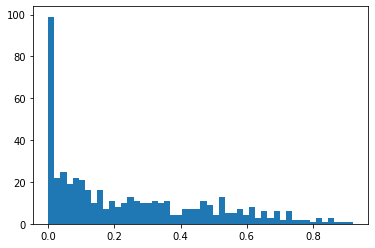

In [85]:
plt.hist(rsquareds[:,1], bins=50)
plt.title('R^2 V1 vs PFC activity histogram')